# Source

The `Source` class provides an interface and predefined methods for reading raw
data from file. If `source.use_nexus == True` the raw data will be saved and
read preferentially from a generated `NeXus` file, which results in a single
data file with high compression and fast data access.

The `Source` class provides a `dict()` of all scans, called `scan_dict`.
The items in this dictionary are instances of the `Scan` class, which defines
the common data structure. However, the access to the scan data should **NOT**
be done via the `scan_dict` directly, but instead for a deticated scan via
`Source.get_scan_data(scan_number)` or for a list of scans via
`Source.get_scan_list_data(scan_number_list)`. By this, all features of the
`Source` class can be utilized.

One key concept of the `pyEvalData` is the idea, that `Scan` instances must
only provide the meta information of the scan but not necessarily its data.
By default, the scan data will only be read on request and is then stored in
the `Scan` object for later use. It is possible, however, to read all data
to each scan directly on first parsing by `Source.read_all_data = Ture`.
On the other hand, if the data is allocating too much memory, it is possible
to clear the data from the `Scan` object, directly after accessing it, via
`Source.read_and_forget = True`. The flag `Source.update_before_read` enables
parsing the raw source file to search and add new scans before accessing any
other scans. By default the last `Scan` in the `scan_dict` will always be
re-created in case new data was added. The flag `Source.force_overwrite` will
force a full parsing of the raw source file and a complete overwrite of the
`NeXus` file on every `update()`.  
With these set of parameters the user is very flexible in how and if the raw
data is read and stored and can adapt the `Source` behaviour for different
situations such as *on-line* anaylsis during a beamtime or *post* analysis
later at home.

The following examples are meant for introducing the low-level access to raw
data via the `Source` layer. This can be helpful for direct access to raw data
and integration into existing scripts and applications.  
However, user will generally access the `Source` via the `Evaluation` class
as described in the [upcoming examples](./evaluation).

## Setup

Here we do the necessary import for this example

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pyEvalData as ped
# define the path for the example data
example_data_path = '../../../example_data/'

## SPEC

A very common data source are SPEC files from the original
[Certif spec application](https://certif.com/content/spec/) as well as from the
open-source alternative [Sardana](https://sardana-controls.org).
The `Spec` source relies on the great parser provided by
[xrayutilities](https://xrayutilities.sourceforge.io).

In [2]:
spec = ped.io.Spec(file_name='certif_xu.spec',
                   file_path=example_data_path,
                   use_nexus=True,
                   force_overwrite=False,
                   update_before_read=False,
                   read_and_forget=True,
                   nexus_file_path='./')

pyEvalData.io.source - INFO: Update source
pyEvalData.io.source - INFO: parse_nexus


As described above, the scan data and meta information should be accessed via
`spec.get_scan_data(scan_number)`.  
Here, `data` is returned as `numpy.recarray` and `meta` is a `dict()`.

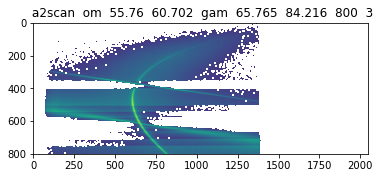

In [3]:
data, meta = spec.get_scan_data(33)

plt.figure()
plt.imshow(np.log10(data['MCA']))
plt.title(meta['cmd'])
plt.show()

One can also directly work with the `Scan` objects, which provides nearly the
same functionality as above but misses to automatically `read_and_forget` the
data. Below, the example from above is reproduces with the `Scan`. Here one can
also easily access the meta information as attributes of the `Scan` instance.

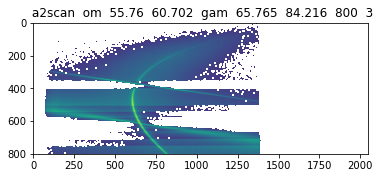

In [4]:
scan = spec.get_scan(33)

plt.figure()
plt.imshow(np.log10(scan.MCA))
plt.title(scan.cmd)
plt.show()

It is also possible to access the scan directly as attribute of the source which
is fully aquivalent to the last example.

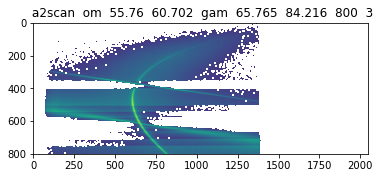

In [5]:
plt.figure()
plt.imshow(np.log10(spec.scan33.MCA))
plt.title(spec.scan33.cmd)
plt.show()

## Sardana NeXus

The [NeXus file format](https://www.nexusformat.org) is a common standard in
science for storing and exchanging data. It is based on
[hdf5](https://www.hdfgroup.org/solutions/hdf5/) files with a hierarchical
structure. As an example we read the NeXus files as created by Sardana.
As we can directly access the data from the NeXus files, there is no need to
enable additional NeXus export so one can set `source.use_nexus = False`.

In [6]:
sarnxs = ped.io.SardanaNeXus(file_name='sardana_nexus.h5',
                             file_path=example_data_path,
                             use_nexus=False,
                             force_overwrite=False,
                             update_before_read=False,
                             read_and_forget=True)

pyEvalData.io.source - INFO: Update source
pyEvalData.io.source - INFO: parse_raw


pyEvalData.io.source - INFO: read_raw_scan_data for scan #435


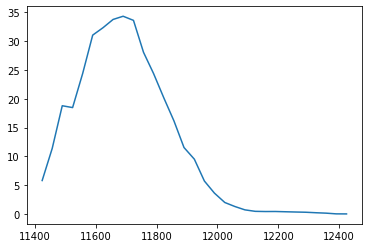

In [7]:
plt.figure()
plt.plot(sarnxs.scan435.mhor, sarnxs.scan435.pmPump)
plt.show()

## hdf5 - PAL FEL

[hdf5](https://www.hdfgroup.org/solutions/hdf5/) is also a very common data
format. In this example the raw data was measured at PAL FEL in South Korea.
The individual files are grouped in a single folder per scan. This is handled
by the `fprint`-statement for the `file_name` is is automatically evaluated
to provide the correct file and folder name for a given scan number.

In [8]:
pal = ped.io.PalH5(name='2020_12_Schick',
                   file_name='{0:07d}',
                   file_path=example_data_path+'/pal_fel',
                   use_nexus=False,
                   force_overwrite=False,
                   update_before_read=True,
                   read_and_forget=True,
                   nexus_file_path='./',
                   nexus_file_name='2020_12_Schick')

pyEvalData.io.source - INFO: Update source
pyEvalData.io.source - INFO: parse_raw


Again we have easy access to the raw data similar to the former examples.

pyEvalData.io.source - INFO: read_raw_scan_data for scan #9


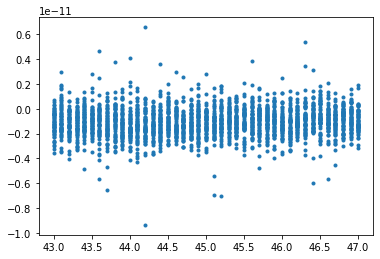

In [9]:
plt.figure()
plt.plot(pal.scan9.th, pal.scan9.digi1_1, '.')
plt.show()

## Composite Sources

**idea for a future release**

One specific idea of the `Source` class is to provide also composite models of
pre-defined `Source` classes. An example is the `Spec` source for reading SPEC
data files and a `Source` class to read camera images from a folder structure,
that have been acquired simultaneously with the SPEC file.
This would require to specify the two independent `Souce` objects and then add
them to a single `CompositeSource`, e.g. by:
```python
spec = ed.io.Spec(file_name, file_path)
ccd = ed.io.Pilatus(image_pattern, image_base_path)

comp_source = spec + ccd
```
After this step the workflow is the same as with all other `Source` classes.
The concatenation should also allow for multiple items. Special care must be
take for duplicate `motor` and `counter` names. This would require a `prefix`
scheme similar to the [`lmfit`](https://lmfit.github.io/lmfit-py/) package.